Epoch 0/5000, Loss: 0.000363
Epoch 500/5000, Loss: 0.000000
Epoch 1000/5000, Loss: 0.000000
Epoch 1500/5000, Loss: 0.000000
Epoch 2000/5000, Loss: 0.000000
Epoch 2500/5000, Loss: 0.000000
Epoch 3000/5000, Loss: 0.000000
Epoch 3500/5000, Loss: 0.000000
Epoch 4000/5000, Loss: 0.000000
Epoch 4500/5000, Loss: 0.000000


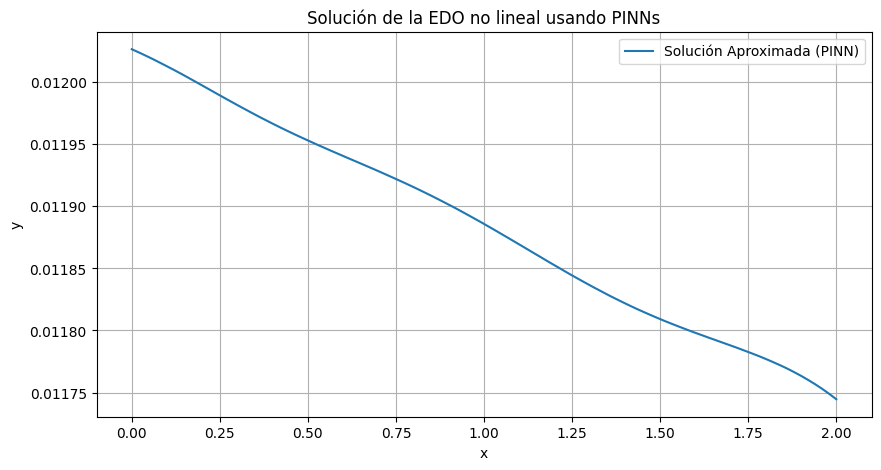

In [ ]:
# Ejemplo básico de resolver una ecuación diferencial no lineal usando Physics-Informed Neural Networks (PINNs) en PyTorch.
# Este ejemplo resuelve la ecuación diferencial no lineal: dy/dx + y^2 = 0.

import torch
import torch.nn as nn

# 1. Definimos la estructura de la red neuronal (PINN).
class PINN(nn.Module):
    def __init__(self):
        """
        Inicializa una red neuronal simple para aproximar la solución de la EDO.
        """
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 20),  # Capa de entrada con 1 variable (x) y 20 neuronas.
            nn.Tanh(),         # Función de activación no lineal.
            nn.Linear(20, 20), # Capa oculta con 20 neuronas.
            nn.Tanh(),         # Función de activación no lineal.
            nn.Linear(20, 1)   # Capa de salida con 1 variable (y).
        )

    def forward(self, x):
        """
        Calcula la salida de la red para la entrada x.

        :param x: Variable independiente (tensor).
        :return: Aproximación de y(x).
        """
        return self.layers(x)

# 2. Definimos la función de pérdida basada en la ecuación diferencial.
def loss_function(model, x):
    """
    Calcula la pérdida para el modelo basándose en la ecuación diferencial no lineal.

    :param model: La red neuronal (PINN).
    :param x: Puntos de la variable independiente (tensor).
    :return: Pérdida (escalar).
    """
    x.requires_grad = True  # Habilita el cálculo automático de gradientes.
    y = model(x)            # Aproximación de y(x) por la red.

    # Calculamos la derivada dy/dx.
    dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

    # Definimos la ecuación diferencial: dy/dx + y^2 = 0.
    ode_residual = dy_dx + y**2

    # Calculamos la pérdida como el error cuadrático medio del residual.
    return torch.mean(ode_residual**2)

# 3. Configuramos el problema y entrenamos el modelo.
# Generamos puntos de entrada para la variable independiente (x).
x_train = torch.linspace(0, 2, 100).view(-1, 1)  # 100 puntos entre 0 y 2.

# Inicializamos el modelo y el optimizador.
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenamos el modelo.
n_epochs = 5000  # Número de épocas de entrenamiento.
for epoch in range(n_epochs):
    optimizer.zero_grad()  # Reseteamos los gradientes.
    loss = loss_function(model, x_train)  # Calculamos la pérdida.
    loss.backward()        # Calculamos los gradientes.
    optimizer.step()       # Actualizamos los parámetros de la red.

    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{n_epochs}, Loss: {loss.item():.6f}")

# 4. Visualizamos los resultados.
import matplotlib.pyplot as plt

# Generamos puntos para evaluar la solución.
x_test = torch.linspace(0, 2, 100).view(-1, 1)
y_pred = model(x_test).detach().numpy()

# Graficamos la solución aproximada.
plt.figure(figsize=(10, 5))
plt.plot(x_test.numpy(), y_pred, label="Solución Aproximada (PINN)")
plt.title("Solución de la EDO no lineal usando PINNs")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.show()


Epoch 0, Loss: 0.960629
Epoch 200, Loss: 0.000035
Epoch 400, Loss: 0.000008
Epoch 600, Loss: 0.000004
Epoch 800, Loss: 0.000003
Epoch 1000, Loss: 0.000002
Epoch 1200, Loss: 0.000002
Epoch 1400, Loss: 0.000001
Epoch 1600, Loss: 0.000001
Epoch 1800, Loss: 0.000001


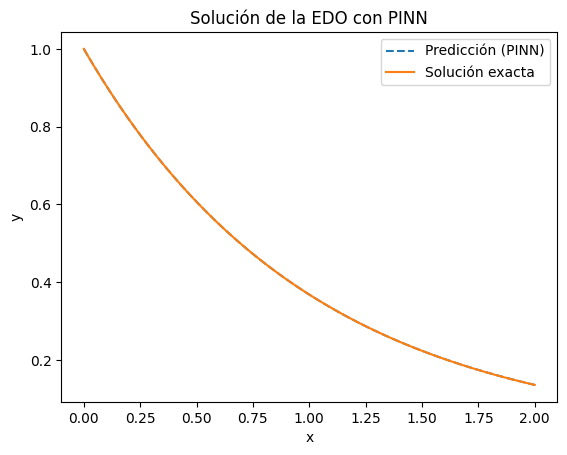

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Definimos la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.hidden(x)

# 2. Definimos la ecuación diferencial y las condiciones iniciales
# Ecuación: dy/dx + y = 0
# Condición inicial: y(0) = 1

def residual(model, x):
    """
    Calcula el residuo de la ecuación diferencial dy/dx + y = 0.
    """
    x.requires_grad = True
    y = model(x)  # y predicho por la red

    # Derivada dy/dx
    dy_dx = torch.autograd.grad(
        outputs=y, inputs=x, grad_outputs=torch.ones_like(y), create_graph=True
    )[0]

    # Residuo R(x) = dy/dx + y
    return dy_dx + y

# 3. Función de pérdida
# Incluye el residuo de la ecuación diferencial y la condición inicial
def loss_function(model, x_collocation, x_boundary, y_boundary):
    """
    Calcula la función de pérdida total.
    """
    # Pérdida del residuo en puntos de colisión
    res = residual(model, x_collocation)
    loss_residual = torch.mean(res**2)

    # Pérdida por condición inicial
    y_pred = model(x_boundary)
    loss_boundary = torch.mean((y_pred - y_boundary)**2)

    # Pérdida total
    return loss_residual + loss_boundary

# 4. Entrenamiento del modelo
def train_pinn():
    # Inicialización
    model = PINN()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Puntos de entrenamiento (colisión) y condición inicial
    x_collocation = torch.linspace(0, 2, 100).reshape(-1, 1)  # Puntos del dominio
    x_boundary = torch.tensor([[0.0]])  # Punto para la condición inicial
    y_boundary = torch.tensor([[1.0]])  # Valor de la condición inicial

    # Ciclo de entrenamiento
    epochs = 2000
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Calcular la pérdida
        loss = loss_function(model, x_collocation, x_boundary, y_boundary)

        # Optimizar
        loss.backward()
        optimizer.step()

        # Mostrar progreso
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    return model

# 5. Evaluación
if __name__ == "__main__":
    # Entrenamos el modelo
    trained_model = train_pinn()

    # Predicción
    x_test = torch.linspace(0, 2, 100).reshape(-1, 1)
    y_pred = trained_model(x_test).detach().numpy()

    # Solución exacta para comparación
    import matplotlib.pyplot as plt
    y_exact = torch.exp(-x_test).numpy()  # Solución analítica: y = e^(-x)

    # Gráfica de resultados
    plt.plot(x_test.numpy(), y_pred, label="Predicción (PINN)", linestyle="--")
    plt.plot(x_test.numpy(), y_exact, label="Solución exacta", linestyle="-")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solución de la EDO con PINN")
    plt.show()


Epoch 0, Loss: 0.640873
Epoch 500, Loss: 0.011931
Epoch 1000, Loss: 0.000727
Epoch 1500, Loss: 0.000272
Epoch 2000, Loss: 0.000178
Epoch 2500, Loss: 0.000138
Epoch 3000, Loss: 0.000105
Epoch 3500, Loss: 0.000071
Epoch 4000, Loss: 0.000043
Epoch 4500, Loss: 0.000029


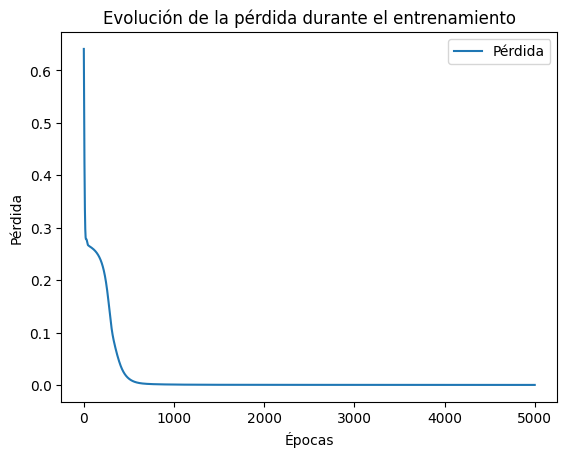

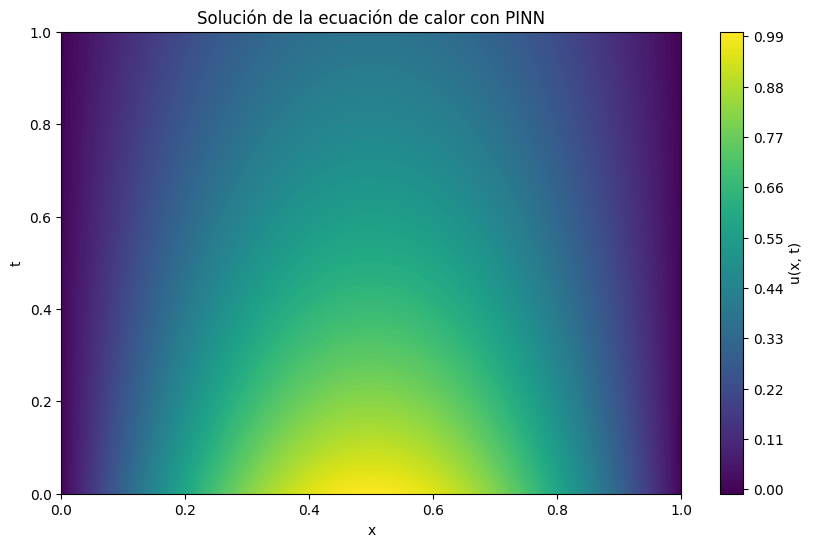

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1. Definimos la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.hidden(x)

# 2. Definimos la ecuación diferencial de calor y las condiciones de frontera
# Ecuación: \partial u / \partial t = \partial^2 u / \partial x^2
# Condiciones de frontera: u(0, t) = 0, u(1, t) = 0
# Condición inicial: u(x, 0) = sin(pi * x)

def residual(model, x, t):
    """
    Calcula el residuo de la ecuación de calor \partial u / \partial t = \partial^2 u / \partial x^2.
    """
    x.requires_grad = True
    t.requires_grad = True

    u = model(torch.cat((x, t), dim=1))  # u predicho por la red

    # Derivada parcial \partial u / \partial t
    du_dt = torch.autograd.grad(
        outputs=u, inputs=t, grad_outputs=torch.ones_like(u), create_graph=True
    )[0]

    # Derivada parcial \partial u / \partial x
    du_dx = torch.autograd.grad(
        outputs=u, inputs=x, grad_outputs=torch.ones_like(u), create_graph=True
    )[0]

    # Segunda derivada \partial^2 u / \partial x^2
    d2u_dx2 = torch.autograd.grad(
        outputs=du_dx, inputs=x, grad_outputs=torch.ones_like(du_dx), create_graph=True
    )[0]

    # Residuo R(x, t) = \partial u / \partial t - \partial^2 u / \partial x^2
    return du_dt - 0.1*d2u_dx2

# 3. Función de pérdida
# Incluye el residuo de la ecuación diferencial, condiciones iniciales y de frontera
def loss_function(model, x_collocation, t_collocation, x_boundary, t_boundary, u_boundary, x_initial, t_initial, u_initial):
    """
    Calcula la función de pérdida total.
    """
    # Pérdida del residuo en puntos de colisión
    res = residual(model, x_collocation, t_collocation)
    loss_residual = torch.mean(res**2)

    # Pérdida por condiciones de frontera
    u_pred_boundary = model(torch.cat((x_boundary, t_boundary), dim=1))
    loss_boundary = torch.mean((u_pred_boundary - u_boundary)**2)

    # Pérdida por condición inicial
    u_pred_initial = model(torch.cat((x_initial, t_initial), dim=1))
    loss_initial = torch.mean((u_pred_initial - u_initial)**2)

    # Pérdida total
    return loss_residual + loss_boundary + loss_initial

# 4. Entrenamiento del modelo
def train_pinn():
    # Inicialización
    model = PINN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Puntos de entrenamiento
    x_collocation = torch.linspace(0, 1, 50).reshape(-1, 1).repeat(1, 50).reshape(-1, 1)
    t_collocation = torch.linspace(0, 1, 50).reshape(1, -1).repeat(50, 1).reshape(-1, 1)

    x_boundary = torch.cat((torch.zeros(50, 1), torch.ones(50, 1)))
    t_boundary = torch.linspace(0, 1, 50).reshape(-1, 1).repeat(2, 1)
    u_boundary = torch.zeros_like(x_boundary)

    x_initial = torch.linspace(0, 1, 50).reshape(-1, 1)
    t_initial = torch.zeros_like(x_initial)
    u_initial = torch.sin(torch.pi * x_initial)

    # Ciclo de entrenamiento
    epochs = 5000
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Calcular la pérdida
        loss = loss_function(model, x_collocation, t_collocation, x_boundary, t_boundary, u_boundary, x_initial, t_initial, u_initial)
        losses.append(loss.item())

        # Optimizar
        loss.backward()
        optimizer.step()

        # Mostrar progreso
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    # Graficar la pérdida
    plt.plot(range(epochs), losses, label="Pérdida")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.title("Evolución de la pérdida durante el entrenamiento")
    plt.legend()
    plt.show()

    return model

# 5. Evaluación
if __name__ == "__main__":
    # Entrenamos el modelo
    trained_model = train_pinn()

    # Predicción
    x_test = torch.linspace(0, 1, 50).reshape(-1, 1).repeat(1, 50).reshape(-1, 1)
    t_test = torch.linspace(0, 1, 50).reshape(1, -1).repeat(50, 1).reshape(-1, 1)
    u_pred = trained_model(torch.cat((x_test, t_test), dim=1)).detach().numpy()

    # Graficar la solución predicha
    X, T = torch.meshgrid(torch.linspace(0, 1, 50), torch.linspace(0, 1, 50))
    U_pred = u_pred.reshape(50, 50)

    plt.figure(figsize=(10, 6))
    plt.contourf(X.numpy(), T.numpy(), U_pred, levels=100, cmap="viridis")
    plt.colorbar(label="u(x, t)")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title("Solución de la ecuación de calor con PINN")
    plt.show()

Epoch 0, Loss: 0.148240
Epoch 500, Loss: 0.087655
Epoch 1000, Loss: 0.085486
Epoch 1500, Loss: 0.075891
Epoch 2000, Loss: 0.068119
Epoch 2500, Loss: 0.062666
Epoch 3000, Loss: 0.055599
Epoch 3500, Loss: 0.049768
Epoch 4000, Loss: 0.046656
Epoch 4500, Loss: 0.044264


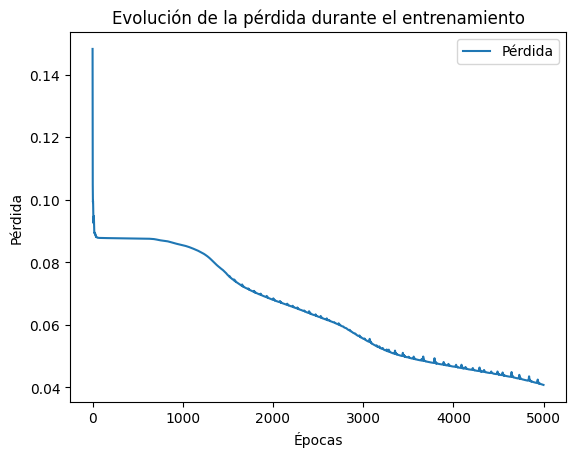

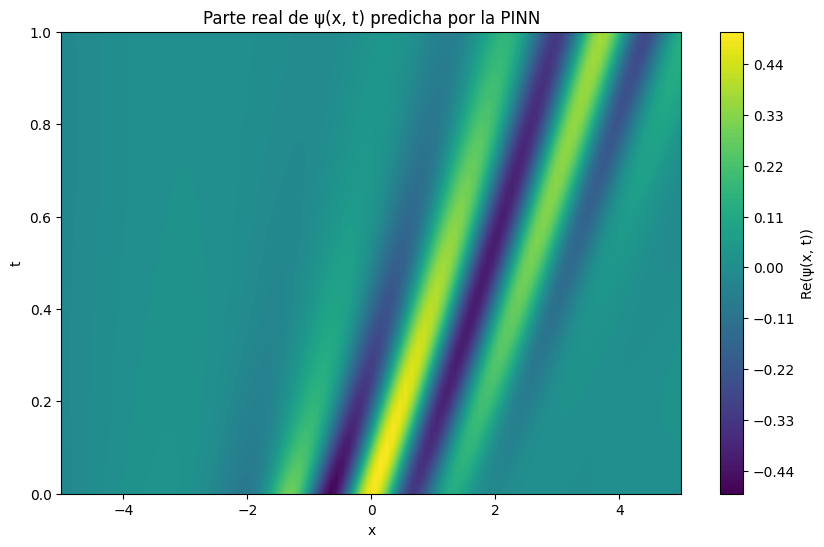

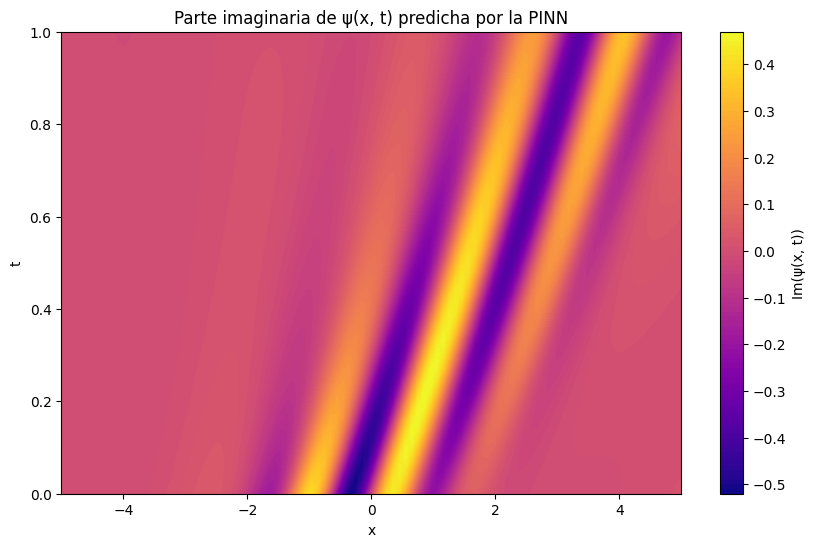

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# 1. Definimos la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2)  # Salida con dos componentes: parte real e imaginaria
        )

    def forward(self, x):
        return self.hidden(x)

# 2. Definimos la ecuación de Schrödinger dependiente del tiempo
# Ecuación: i * \partial \psi / \partial t = -\partial^2 \psi / \partial x^2 + V(x)\psi
# Consideramos un potencial nulo: V(x) = 0

# Constantes
hbar = 1.0  # Constante de Planck reducida
m = 1.0     # Masa de la partícula

def residual(model, x, t):
    """
    Calcula el residuo de la ecuación de Schrödinger.
    """
    x.requires_grad = True
    t.requires_grad = True

    psi = model(torch.cat((x, t), dim=1))  # \psi predicho por la red
    psi_real = psi[:, 0:1]  # Parte real
    psi_imag = psi[:, 1:2]  # Parte imaginaria

    # Derivadas parciales \partial \psi / \partial t
    dpsi_real_dt = torch.autograd.grad(
        outputs=psi_real, inputs=t, grad_outputs=torch.ones_like(psi_real), create_graph=True
    )[0]
    dpsi_imag_dt = torch.autograd.grad(
        outputs=psi_imag, inputs=t, grad_outputs=torch.ones_like(psi_imag), create_graph=True
    )[0]

    # Derivadas parciales \partial^2 \psi / \partial x^2
    dpsi_real_dx = torch.autograd.grad(
        outputs=psi_real, inputs=x, grad_outputs=torch.ones_like(psi_real), create_graph=True
    )[0]
    dpsi_imag_dx = torch.autograd.grad(
        outputs=psi_imag, inputs=x, grad_outputs=torch.ones_like(psi_imag), create_graph=True
    )[0]

    d2psi_real_dx2 = torch.autograd.grad(
        outputs=dpsi_real_dx, inputs=x, grad_outputs=torch.ones_like(dpsi_real_dx), create_graph=True
    )[0]
    d2psi_imag_dx2 = torch.autograd.grad(
        outputs=dpsi_imag_dx, inputs=x, grad_outputs=torch.ones_like(dpsi_imag_dx), create_graph=True
    )[0]

    # Residuo para las partes real e imaginaria
    res_real = dpsi_real_dt + (hbar / (2 * m)) * d2psi_imag_dx2
    res_imag = dpsi_imag_dt - (hbar / (2 * m)) * d2psi_real_dx2

    return res_real, res_imag

# 3. Función de pérdida
# Incluye el residuo de la ecuación de Schrödinger y las condiciones iniciales

def loss_function(model, x_collocation, t_collocation, x_initial, t_initial, psi_initial):
    """
    Calcula la función de pérdida total.
    """
    # Pérdida del residuo en puntos de colisión
    res_real, res_imag = residual(model, x_collocation, t_collocation)
    loss_residual = torch.mean(res_real**2 + res_imag**2)

    # Pérdida por condición inicial
    psi_pred_initial = model(torch.cat((x_initial, t_initial), dim=1))
    loss_initial = torch.mean((psi_pred_initial - psi_initial)**2)

    # Pérdida total
    return loss_residual + loss_initial

# 4. Entrenamiento del modelo
def train_pinn():
    # Inicialización
    model = PINN()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Puntos de entrenamiento
    x_collocation = torch.linspace(-5, 5, 100).reshape(-1, 1).repeat(1, 100).reshape(-1, 1)
    t_collocation = torch.linspace(0, 1, 100).reshape(1, -1).repeat(100, 1).reshape(-1, 1)

    x_initial = torch.linspace(-5, 5, 100).reshape(-1, 1)
    t_initial = torch.zeros_like(x_initial)

    # Condición inicial: paquete de ondas gaussiano
    sigma = 1.0
    k0 = 5.0
    psi_initial_real = torch.exp(-x_initial**2 / (2 * sigma**2)) * torch.cos(k0 * x_initial)
    psi_initial_imag = torch.exp(-x_initial**2 / (2 * sigma**2)) * torch.sin(k0 * x_initial)
    psi_initial = torch.cat((psi_initial_real, psi_initial_imag), dim=1)

    # Ciclo de entrenamiento
    epochs = 5000
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Calcular la pérdida
        loss = loss_function(model, x_collocation, t_collocation, x_initial, t_initial, psi_initial)
        losses.append(loss.item())

        # Optimizar
        loss.backward()
        optimizer.step()

        # Mostrar progreso
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    # Graficar la pérdida
    plt.plot(range(epochs), losses, label="Pérdida")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.title("Evolución de la pérdida durante el entrenamiento")
    plt.legend()
    plt.show()

    return model

# 5. Evaluación
if __name__ == "__main__":
    # Entrenamos el modelo
    trained_model = train_pinn()

    # Predicción
    x_test = torch.linspace(-5, 5, 100).reshape(-1, 1).repeat(1, 100).reshape(-1, 1)
    t_test = torch.linspace(0, 1, 100).reshape(1, -1).repeat(100, 1).reshape(-1, 1)
    psi_pred = trained_model(torch.cat((x_test, t_test), dim=1)).detach().numpy()

    # Separar partes real e imaginaria
    psi_pred_real = psi_pred[:, 0].reshape(100, 100)
    psi_pred_imag = psi_pred[:, 1].reshape(100, 100)

    # Graficar la solución predicha (parte real)
    X, T = torch.meshgrid(torch.linspace(-5, 5, 100), torch.linspace(0, 1, 100))

    plt.figure(figsize=(10, 6))
    plt.contourf(X.numpy(), T.numpy(), psi_pred_real, levels=100, cmap="viridis")
    plt.colorbar(label="Re(\u03C8(x, t))")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title("Parte real de \u03C8(x, t) predicha por la PINN")
    plt.show()

    # Graficar la solución predicha (parte imaginaria)
    plt.figure(figsize=(10, 6))
    plt.contourf(X.numpy(), T.numpy(), psi_pred_imag, levels=100, cmap="plasma")
    plt.colorbar(label="Im(\u03C8(x, t))")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title("Parte imaginaria de \u03C8(x, t) predicha por la PINN")
    plt.show()
